In [1]:
from IPython.core.display import display, HTML
from IPython import display as idisplay

import time

import pandas as pd
import numpy as np
import scipy.stats as scs
from scipy.stats import multivariate_normal as mvn
import sklearn.mixture as mix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# K-Means

K-Means is an unsupervised learning algorithm used for clustering multidimensional data sets.

The basic form of K-Means makes two assumptions

    1. Each data point is closer to its own cluster center than the other cluster centers
    2. A cluster center is the arithmetic mean of all the points that belong to the cluster.

The algorithm consists of two main steps:

* The expectation step is done by calculating the pairwise distances of every data point and every cluster center and assigning cluster membership to the closest center

* The maximization step is recomputing the cluster centers by taking the arithmetic mean of the assigned data points for each cluster


In [2]:
# Let's define some demo variables and make some blobs

# demo variables

k = 4
n_draws = 500
sigma = .7
random_state = 0
dot_size = 50
cmap = 'viridis'

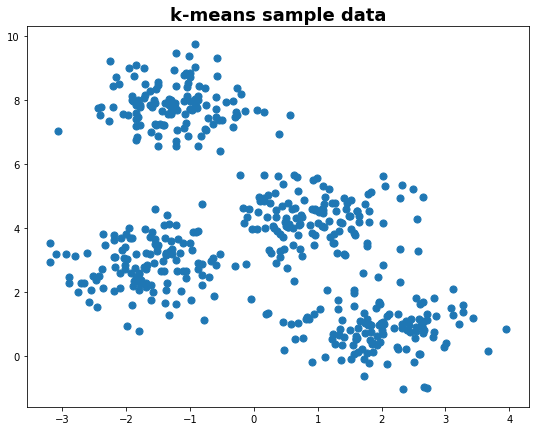

In [3]:
# make blobs

from sklearn.datasets.samples_generator import make_blobs

X, y_true = make_blobs(n_samples = n_draws,
                       centers = k,
                       cluster_std = sigma,
                       random_state = random_state)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X[:, 0], X[:, 1], s=dot_size)
_ = plt.title('k-means sample data', fontsize=18, fontweight='demi')

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Random initialization (choose random clusters)
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    
    # initial centoid coordinates
    centers = X[i]
    it = 1
    
    while True:
        # 2 Assign labels based on closest center
        # your code goes here
        labels = pairwise_distances_argmin(X, centers)

        # 3 Find new centroids from means of points
        # your code goes here
        new_centers = np.array([X[labels == i].mean(0) 
                                for i in range(n_clusters)])

        # 4 Check for convergence
        if np.all(centers == new_centers):
            break
            
        centers = new_centers
        
        fig, ax = plt.subplots(figsize=(9,7))
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=dot_size, cmap=cmap)
        plt.title('iteration {}'.format(it), fontsize=18, fontweight='demi')
        it += 1
    
    return centers, labels

Text(0.5,1,'find_clusters() k-means func')

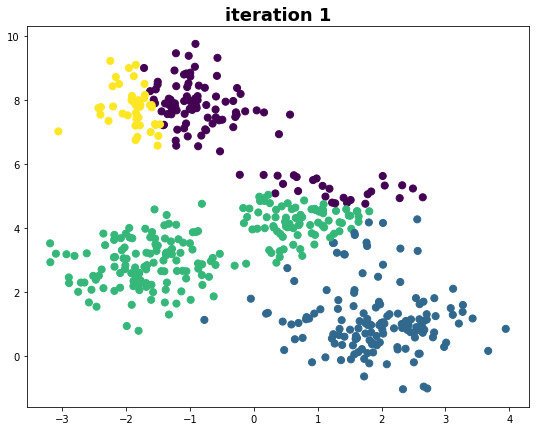

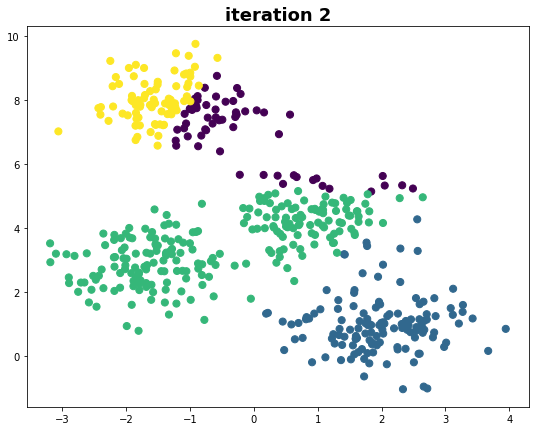

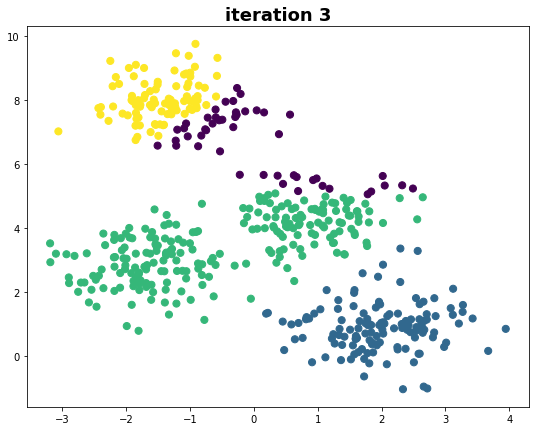

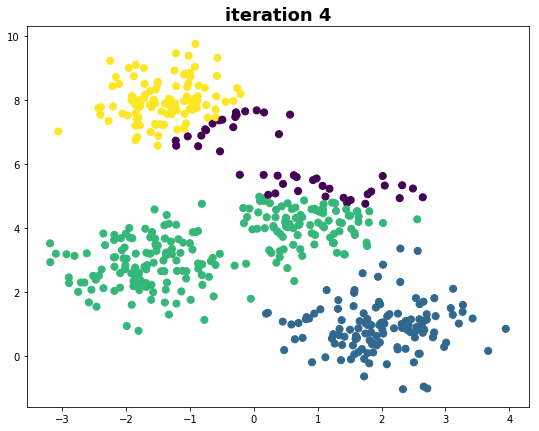

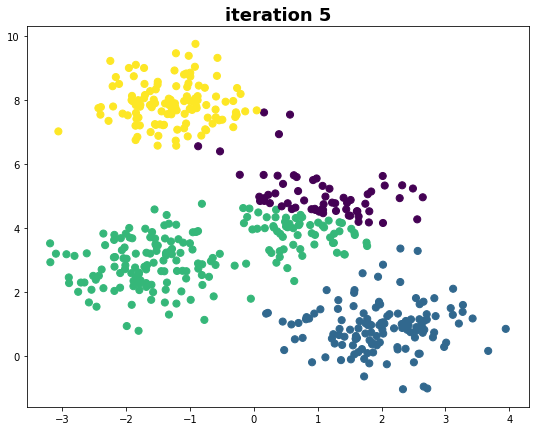

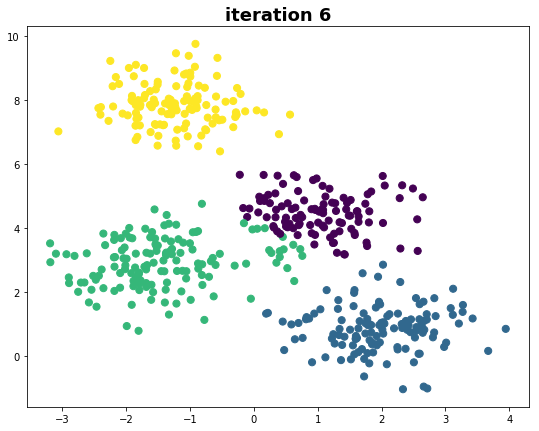

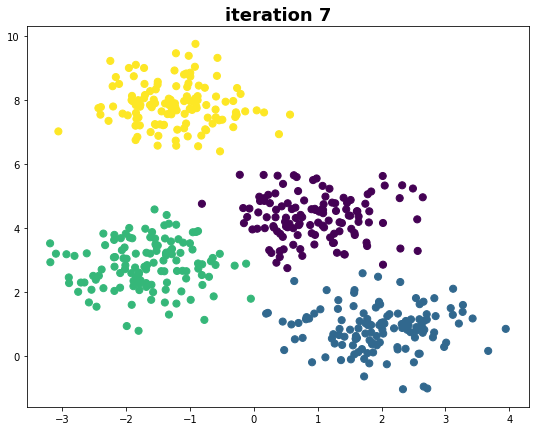

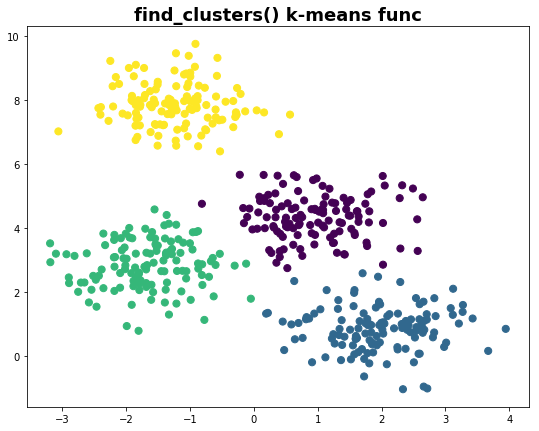

In [6]:
# let's test the implementation

centers, labels = find_clusters(X, k)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X[:, 0], X[:, 1], c=labels, s=dot_size, cmap=cmap)
plt.title('find_clusters() k-means result', fontsize=18, fontweight='demi')

Text(0.5,1,'sklearn k-means')

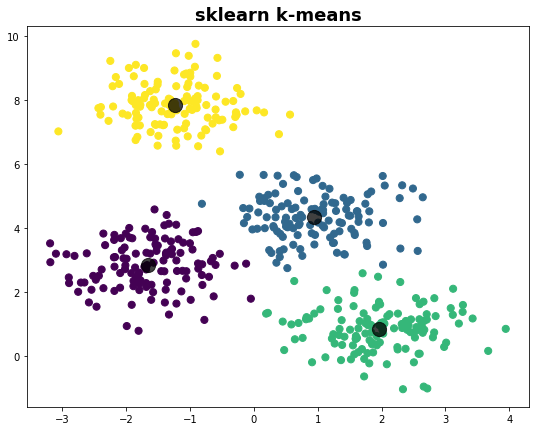

In [7]:
# now let's compare this to the sklearn's KMeans() algorithm

# fit k-means to blobs

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# visualize prediction
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=dot_size, cmap=cmap)

# get centers for plot
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
_ = plt.title('sklearn k-means', fontsize=18, fontweight='demi')

### Now we are ready to explore some of the nuances/issues of implementing K-Means as an expectation maximization algorithm

### the globally optimal result is not guaranteed
    - EM is guaranteed to improve the result in each iteration but there are no guarantees that it will find the global best. See the following example, where we initalize the algorithm with a different seed.

### practical solution: 
    - Run the algorithm w/ multiple random initializations
    - This is done by default in sklearn

[247 239  70 136]


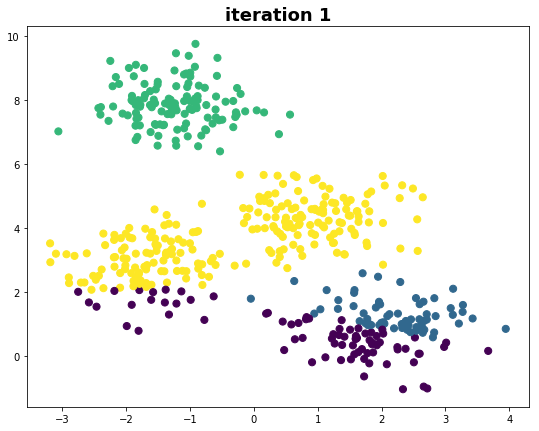

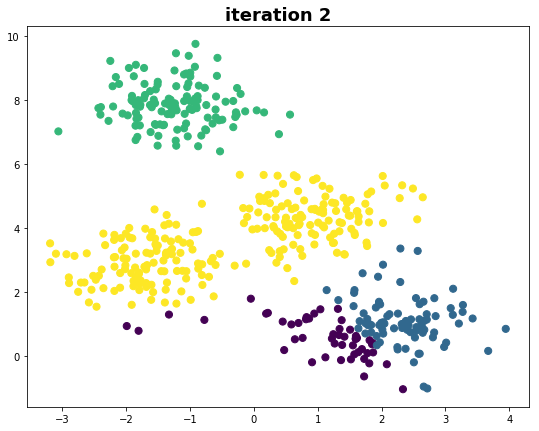

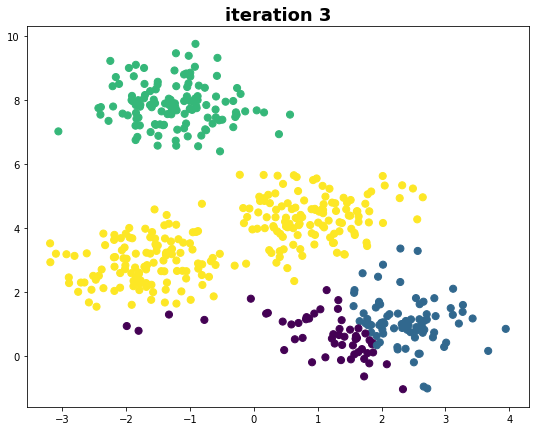

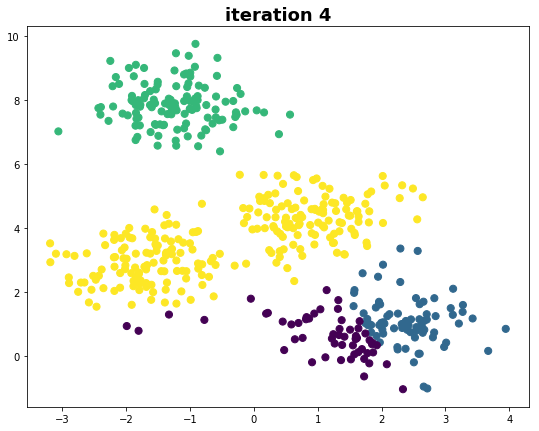

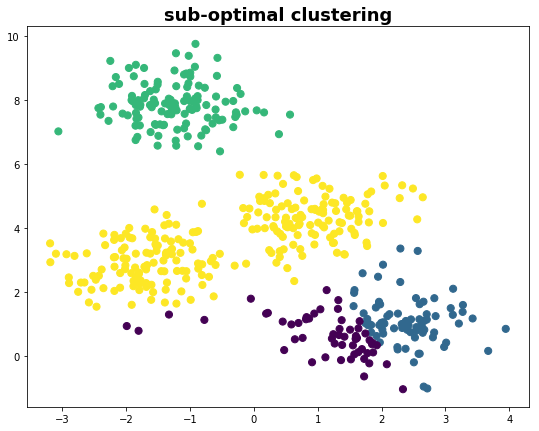

In [43]:
centers, labels = find_clusters(X, k, rseed=11)

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('sub-optimal clustering', fontsize=18, fontweight='demi')
ax.scatter(X[:, 0], X[:, 1], c=labels, s=dot_size, cmap=cmap)

### number of means (clusters) have to be selected beforehand
    - k-means cannot learn the optimal number of clusters from the data. If we ask for six clusters it will find six clusters, which may or may not be meaningful.
    
### practical solution:
    - use a more complex clustering algorithm like Gaussian Mixture Models, or one that can choose a suitable number of clusters (DBSCAN, mean-shift, affinity propagation)

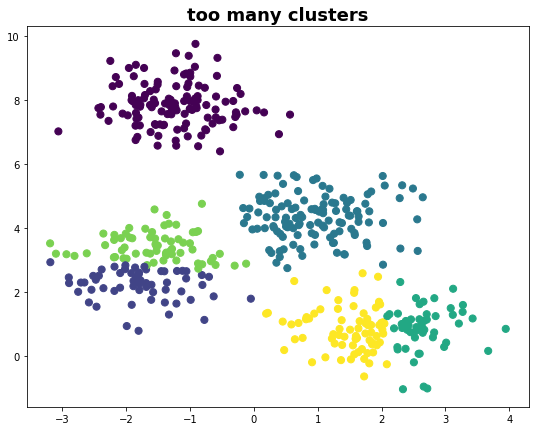

In [44]:
labels6 = KMeans(6, random_state=random_state).fit_predict(X)

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('too many clusters', fontsize=18, fontweight='demi')
ax.scatter(X[:, 0], X[:, 1], c=labels6, s=dot_size, cmap=cmap)

### k-means is terrible for non-linear data:
    - this results because of the assumption that points will be closer to their own cluster center than others

### practical solutions:
    - transform data into higher dimension where linear separation is possible e.g., spectral clustering

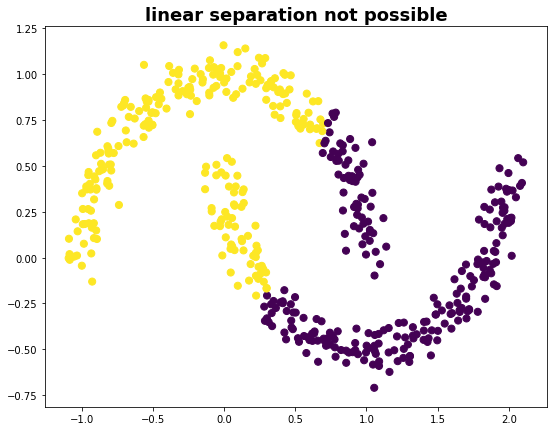

In [45]:
from sklearn.datasets import make_moons

X_mn, y_mn = make_moons(500, noise=.07, random_state=random_state)

labelsM = KMeans(2, random_state=random_state).fit_predict(X_mn)

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('linear separation not possible', fontsize=18, fontweight='demi')
ax.scatter(X_mn[:, 0], X_mn[:, 1], c=labelsM, s=dot_size, cmap=cmap)

### K-Means is known as a hard clustering algorithm because clusters are not allowed to overlap.  

> ___"One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.___ -- <cite> [Jake VanderPlas Python Data Science Handbook] [1]</cite>

[1]:http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb

Text(0.5,1,'Clusters are hard circular boundaries')

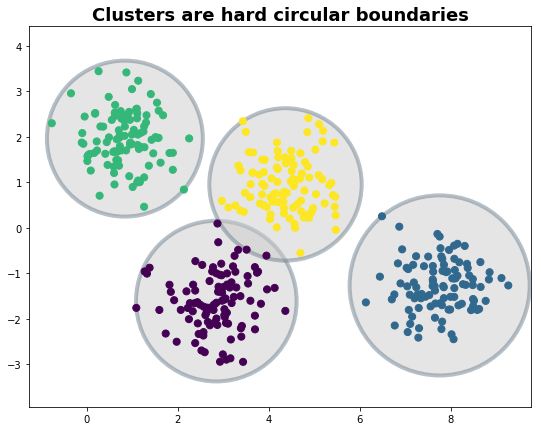

In [47]:
# k-means weaknesses that mixture models address directly
# code sourced from:
#   http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb

from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=k, rseed=2, ax=None):
    labels = kmeans.fit_predict(X)
    
    # plot input data
    #ax = ax or plt.gca() # <-- nice trick
    fig, ax = plt.subplots(figsize=(9,7))    
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1],
               c=labels, s=dot_size, cmap=cmap, zorder=2)
    
    # plot the representation of Kmeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels==i], [center]).max() 
             for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC',edgecolor='slategrey',
                                lw=4, alpha=0.5, zorder=1))
    return      
                     
X3, y_true = make_blobs(n_samples = 400,
                       centers = k,
                       cluster_std = .6,
                       random_state = random_state)
X3 = X3[:, ::-1] # better plotting

kmeans = KMeans(n_clusters=k, random_state=random_state)
plot_kmeans(kmeans, X3)
plt.title('Clusters are hard circular boundaries', fontsize=18, fontweight='demi')

#### A resulting issue of K-Means' circular boundaries is that it has no way to account for oblong or elliptical clusters. 

Text(0.5,1,'Clusters cannot adjust to elliptical data structures')

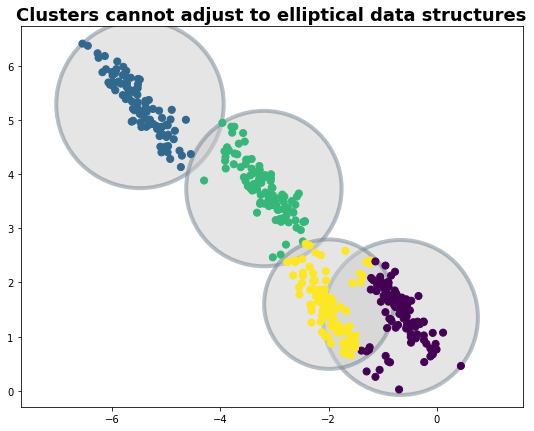

In [48]:
rng = np.random.RandomState(13)
X3_stretched = np.dot(X3, rng.randn(2, 2))

kmeans = KMeans(n_clusters=k, random_state=random_state)
plot_kmeans(kmeans, X3_stretched)
plt.title('Clusters cannot adjust to elliptical data structures',
         fontsize=18, fontweight='demi')